### Creating a Naive Bayes model on the News Category Dataset

#### Loading libraries

In [1]:
import pandas as pd
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sidri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sidri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\sidri\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

#### Loading the dataset

The dataset is loaded from the json file in the data folder. For training, we have kept 12 news categories, and also merged similar categories together in order to reduce noise and minimize model confusion.

The headline and the short description of the article are joined together to add further detail.

In [2]:
df = pd.read_json("data/News_Category_Dataset_v3.json", lines=True)
df['text'] = df['headline'] + " " + df['short_description']

categories = {
    'POLITICS': 'POLITICS', 'WELLNESS': 'WELLNESS', 'HEALTHY LIVING': 'WELLNESS',
    'FIFTY': 'WELLNESS', 'ENTERTAINMENT': 'ENTERTAINMENT', 'TRAVEL': 'TRAVEL',
    'STYLE & BEAUTY': 'STYLE & BEAUTY', 'FOOD & DRINK': 'FOOD & DRINK',
    'TASTE': 'FOOD & DRINK', 'BUSINESS': 'BUSINESS', 'MONEY': 'BUSINESS',
    'COMEDY': 'COMEDY', 'SPORTS': 'SPORTS', 'WORLD NEWS': 'WORLD NEWS',
    'WORLDPOST': 'WORLD NEWS', 'THE WORLDPOST': 'WORLD NEWS',
    'TECH': 'TECH', 'SCIENCE': 'SCIENCE'
}

df['category'] = df['category'].map(categories)
df = df.dropna(subset=['category']).copy()

#### Preprocessing data
For training Naive Bayes, it is necessary to preprocess the data and make it ready. We have used a lemmatizer imported from nltk, which reduces words to their base form, e.g. 'better' becomes 'good'. We also remove stop words in the clean() method and separate the dataset in train and test batches.

In [3]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean(text):
    text = text.lower()
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    clean_tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]

    return " ".join(clean_tokens)

df['text_clean'] = df['text'].apply(clean)

X_train, X_test, y_train, y_test = train_test_split(
    df['text_clean'],
    df['category'],
    test_size=0.2,
    random_state=42,
    stratify=df['category']
)

#### Fitting the data to the model
An imported step before fitting the data to the model, is applying the TF-IDF Vectorizer, a measure for the importance of words in a document. The ngrams parameter also makes sure words are analyzed in groups of two, for example 'white' + 'house' are taken together as 'white house'.
After fitting the data to the model we dump both the naive bayes model and the vectorizer in order to use the model to make predictions later.

In [4]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=30000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


nb_model = MultinomialNB(alpha=0.1, fit_prior=False)
nb_model.fit(X_train_tfidf, y_train)

y_pred = nb_model.predict(X_test_tfidf)

import joblib

joblib.dump(nb_model, 'naive_bayes_model/naive_bayes_model.pkl')
joblib.dump(tfidf, 'naive_bayes_model/tfidf_vectorizer.pkl')

print("Model and Vectorizer exported successfully!")

Model and Vectorizer exported successfully!


#### Evaluation
Evaluating the model by generating the classification report and confusion matrix and measuring the accuracy.

Accuracy: 76.93%

Classification Report:

                precision    recall  f1-score   support

      BUSINESS       0.55      0.66      0.60      1550
        COMEDY       0.48      0.59      0.53      1080
 ENTERTAINMENT       0.83      0.76      0.79      3473
  FOOD & DRINK       0.75      0.85      0.80      1687
      POLITICS       0.92      0.77      0.84      7121
       SCIENCE       0.49      0.61      0.54       441
        SPORTS       0.71      0.83      0.77      1015
STYLE & BEAUTY       0.84      0.82      0.83      1963
          TECH       0.45      0.61      0.52       421
        TRAVEL       0.72      0.80      0.75      1980
      WELLNESS       0.84      0.79      0.81      5208
    WORLD NEWS       0.67      0.81      0.73      1908

      accuracy                           0.77     27847
     macro avg       0.69      0.74      0.71     27847
  weighted avg       0.79      0.77      0.77     27847



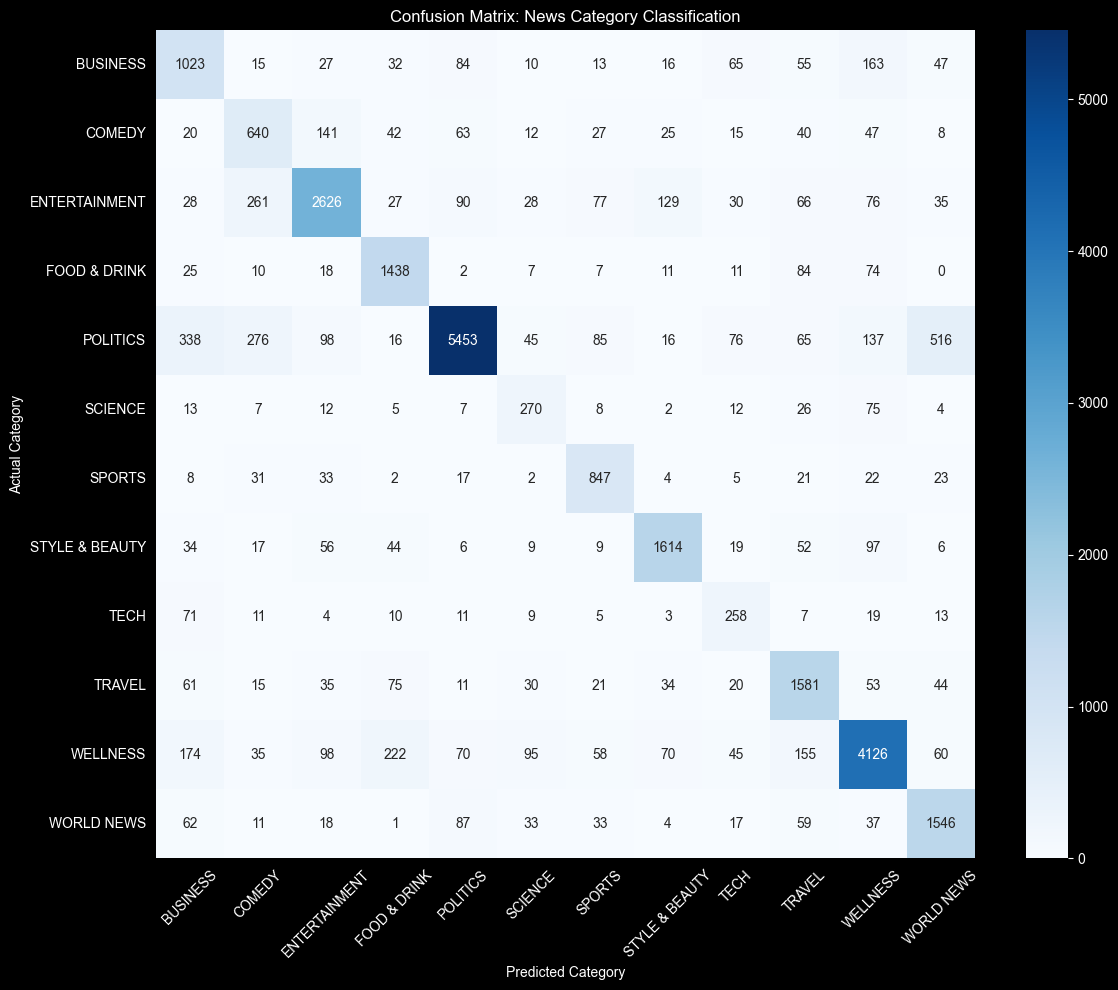

In [5]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

class_names = nb_model.classes_

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title('Confusion Matrix: News Category Classification')
plt.ylabel('Actual Category')
plt.xlabel('Predicted Category')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Save the plot
plt.savefig('confusion_matrix.png')
plt.show()